In [3]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sgp4.ext import invjday
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta
from skyfield.api import load, wgs84, EarthSatellite
from multiprocessing import set_start_method, Process, cpu_count

In [4]:
username = 'asas4539@hanyang.ac.kr'
password = 'onsaemiro1729!!'

In [5]:
def get_tle():
    # Space-Track API의 URL
    url = "https://www.space-track.org/ajaxauth/login"

    # 요청에 필요한 인증 정보
    payload = {"identity": username, "password": password}

    # Session 객체 생성
    session = requests.Session()

    # 로그인 요청
    response = session.post(url, data=payload)

    if response.status_code != 200:
        print("로그인에 실패했습니다.")
        return None

    # TLE 요청
    response = session.get(
        f"https://www.space-track.org/basicspacedata/query/class/tle/NORAD_CAT_ID/58400/EPOCH/2023-11-21--2024-07-24/orderby/EPOCH%20asc/format/3le/emptyresult/show"
    )

    return response

In [6]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [7]:
response = get_tle()
tle_datas = response.text.split('\r\n')

tle_first_lst = []
tle_second_lst = []

for i in range(0, len(tle_datas) - 2, 3):
    tle_first_lst.append(tle_datas[i + 1])
    tle_second_lst.append(tle_datas[i + 2])

tle_df = pd.DataFrame({'first_line': tle_first_lst, 'second_line': tle_second_lst})
tle_df.drop_duplicates(keep='first', inplace=True)
tle_df.reset_index(inplace=True, drop=True)

In [8]:
change_times = []
for i in range(len(tle_df)):
    tle_1, tle_2 = tle_df['first_line'].iloc[i], tle_df['first_line'].iloc[i]
    satellite = Satrec.twoline2rv(tle_1, tle_2)
    jdsatepoch = satellite.jdsatepoch
    jdsatepochfrac = satellite.jdsatepochF
    epochdatetime = invjday(jdsatepoch + jdsatepochfrac)
    change_times.append(epochdatetime)

In [9]:
change_df = pd.DataFrame(change_times)
change_df.columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
change_df['first_line'] = tle_df['first_line']
change_df['second_line'] = tle_df['second_line']
change_df['time'] = pd.to_datetime(change_df[['year', 'month', 'day', 'hour', 'minute', 'second']])
change_df['time'].drop_duplicates(keep='first', inplace=True)

In [8]:
epoch = datetime(2023, 11, 22, 0, 15, 0, 0)
all_info = []
earth_radius = 6378.137
rad2deg = 180.0 / np.pi

while epoch < datetime(2024, 8, 1, 0, 0, 0, 0):
    print(epoch)
    year = epoch.year
    month = epoch.month
    date = epoch.day
    hour = epoch.hour
    minute = epoch.minute
    second = epoch.second

    now_time = f'{year}-{month}-{date} {hour}:{minute}:{second}'
    temp = change_df[change_df['time'] <= pd.to_datetime(now_time)].copy()
    tle1, tle2 = temp.iloc[-1]['first_line'], temp.iloc[-1]['second_line']

    satellite = Satrec.twoline2rv(tle1, tle2)
    jd, fr = jday(year, month, date, hour, minute, 0)
    e, position, velocity = satellite.sgp4(jd, fr)

    # 현재 시간 설정
    ts = load.timescale()
    t = ts.utc(year, month, date, hour, minute, 0)

    # EarthSatellite 객체 생성
    earth_satellite = EarthSatellite(tle1, tle2, '', ts)

    # 위성의 지구 중심 좌표 및 속도 계산
    geocentric = earth_satellite.at(t)

    # 위성의 위치를 지구의 위도와 경도로 변환
    subpoint = wgs84.subpoint(geocentric)

    # 위도, 경도 및 고도 추출
    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees

    # 지구 중심으로부터 특정 지점까지의 거리 계산
    geocentric = wgs84.latlon(latitude, longitude).at(t)
    earth_radius = geocentric.distance().km

    print(f"Earth Radius at Location ({latitude}, {longitude}): {earth_radius:.2f} km")

    all_info.append([
        len(temp), tle1, tle2,
        epoch.year, epoch.month, epoch.day, epoch.hour, epoch.minute, epoch.second,
        *position, *velocity,
        (sum(p ** 2 for p in
             position) ** 0.5) - earth_radius,
        (sum(v ** 2 for v in velocity) ** 0.5) / earth_radius,
        satellite.alta * earth_radius,
        satellite.altp * earth_radius,
        satellite.inclo * rad2deg, satellite.ecco,
        satellite.nodeo
    ])

    epoch += timedelta(minutes=1)

2023-11-22 00:15:00
Earth Radius at Location (2.1159264564785207, 146.02518160119666): 6378.11 km
2023-11-22 00:16:00
Earth Radius at Location (5.909867711013013, 145.28067554314924): 6377.91 km
2023-11-22 00:17:00
Earth Radius at Location (9.70252607056457, 144.52944570287184): 6377.53 km
2023-11-22 00:18:00
Earth Radius at Location (13.493183225980552, 143.76689630247253): 6376.98 km
2023-11-22 00:19:00
Earth Radius at Location (17.281115115654533, 142.98802302261086): 6376.26 km
2023-11-22 00:20:00
Earth Radius at Location (21.065585783171034, 142.18720895790293): 6375.39 km
2023-11-22 00:21:00
Earth Radius at Location (24.84583734677897, 141.35797042698405): 6374.39 km
2023-11-22 00:22:00
Earth Radius at Location (28.621074251179284, 140.492627045105): 6373.26 km
2023-11-22 00:23:00
Earth Radius at Location (32.3904391975401, 139.58185866727493): 6372.04 km
2023-11-22 00:24:00
Earth Radius at Location (36.15297686582646, 138.6140925375301): 6370.74 km
2023-11-22 00:25:00
Earth Radi


KeyboardInterrupt



In [8]:
epoch = datetime(2023, 11, 22, 0, 15, 0, 0)
all_info = []
earth_radius = 6378.137
rad2deg = 180.0 / np.pi

while epoch < datetime(2024, 7, 24, 1, 0, 0, 0):
    print(epoch)
    year = epoch.year
    month = epoch.month
    date = epoch.day
    hour = epoch.hour
    minute = epoch.minute
    second = epoch.second

    now_time = f'{year}-{month}-{date} {hour}:{minute}:{second}'
    temp = change_df[change_df['time'] <= pd.to_datetime(now_time)].copy()
    tle1, tle2 = temp.iloc[-1]['first_line'], temp.iloc[-1]['second_line']

    satellite = Satrec.twoline2rv(tle1, tle2)
    jd, fr = jday(year, month, date, hour, minute, 0)
    e, position, velocity = satellite.sgp4(jd, fr)

    # 현재 시간 설정
    ts = load.timescale()
    t = ts.utc(year, month, date, hour, minute, 0)

    # EarthSatellite 객체 생성
    earth_satellite = EarthSatellite(tle1, tle2, '', ts)

    # 위성의 지구 중심 좌표 및 속도 계산
    geocentric = earth_satellite.at(t)

    # 위성의 위치를 지구의 위도와 경도로 변환
    subpoint = wgs84.subpoint(geocentric)

    # 위도, 경도 및 고도 추출
    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees

    # 지구 중심으로부터 특정 지점까지의 거리 계산
    geocentric = wgs84.latlon(latitude, longitude).at(t)
    earth_radius = geocentric.distance().km

    print(f"Earth Radius at Location ({latitude}, {longitude}): {earth_radius:.2f} km")

    all_info.append([
        len(temp), tle1, tle2,
        epoch.year, epoch.month, epoch.day, epoch.hour, epoch.minute, epoch.second,
        *position, *velocity,
        (sum(p ** 2 for p in
             position) ** 0.5) - earth_radius,
        (sum(v ** 2 for v in velocity) ** 0.5) / earth_radius,
        satellite.alta * earth_radius,
        satellite.altp * earth_radius,
        satellite.inclo * rad2deg, satellite.ecco,
        satellite.nodeo
    ])

    epoch += timedelta(minutes=1)

2023-11-22 00:15:00
Earth Radius at Location (2.1159264564785207, 146.02518160119666): 6378.11 km
2023-11-22 00:16:00
Earth Radius at Location (5.909867711013013, 145.28067554314924): 6377.91 km
2023-11-22 00:17:00
Earth Radius at Location (9.70252607056457, 144.52944570287184): 6377.53 km
2023-11-22 00:18:00
Earth Radius at Location (13.493183225980552, 143.76689630247253): 6376.98 km
2023-11-22 00:19:00
Earth Radius at Location (17.281115115654533, 142.98802302261086): 6376.26 km
2023-11-22 00:20:00
Earth Radius at Location (21.065585783171034, 142.18720895790293): 6375.39 km
2023-11-22 00:21:00
Earth Radius at Location (24.84583734677897, 141.35797042698405): 6374.39 km
2023-11-22 00:22:00
Earth Radius at Location (28.621074251179284, 140.492627045105): 6373.26 km
2023-11-22 00:23:00
Earth Radius at Location (32.3904391975401, 139.58185866727493): 6372.04 km
2023-11-22 00:24:00
Earth Radius at Location (36.15297686582646, 138.6140925375301): 6370.74 km
2023-11-22 00:25:00
Earth Radi


KeyboardInterrupt



In [75]:
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
from astropy.coordinates import ITRS
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time

epoch = datetime(2023, 11, 22, 0, 15, 0, 0)
all_info = []

rad2deg = 180.0 / np.pi

while epoch < datetime(2024, 7, 24, 1, 0, 0, 0):
    print(epoch)
    year = epoch.year
    month = epoch.month
    date = epoch.day
    hour = epoch.hour
    minute = epoch.minute
    second = epoch.second

    now_time = f'{year}-{month}-{date} {hour}:{minute}:{second}'
    temp = change_df[change_df['time'] <= pd.to_datetime(now_time)].copy()
    tle1, tle2 = temp.iloc[-1]['first_line'], temp.iloc[-1]['second_line']

    satellite = Satrec.twoline2rv(tle1, tle2)
    jd, fr = jday(year, month, date, hour, minute, 0)
    e, temp_p, temp_v = satellite.sgp4(jd, fr)
    t = Time(jd + fr, format='jd')

    e, position, velocity = satellite.sgp4(t.jd1, t.jd2)
    position = CartesianRepresentation(position * u.km)
    velocity = CartesianDifferential(velocity * u.km / u.s)
    teme = TEME(position.with_differentials(velocity), obstime=t)
    itrs_geo = teme.transform_to(ITRS(obstime=t))
    location = itrs_geo.earth_location
    print(location.geodetic)

    distance = (sum(p ** 2 for p in temp_p) ** 0.5)
    height = location.geodetic.height.to_value(u.km)
    earth_radius = distance - height
    print(earth_radius)

    all_info.append([
        len(temp), tle1, tle2,
        epoch.year, epoch.month, epoch.day, epoch.hour, epoch.minute, epoch.second,
        *temp_p, *temp_v,
        height,
        (sum(v ** 2 for v in temp_v) ** 0.5),
        (sum(v ** 2 for v in temp_v) ** 0.5) / earth_radius,
        satellite.alta * earth_radius,
        satellite.altp * earth_radius,
        satellite.inclo * rad2deg, satellite.ecco,
        satellite.nodeo
    ])

    epoch += timedelta(hours=1)

2023-11-22 00:15:00
GeodeticLocation(lon=<Longitude 146.02518228 deg>, lat=<Latitude 2.11601854 deg>, height=<Quantity 504.12326054 km>)
6882.231335643091
504.1232605419948
6378.108075101097
2023-11-22 01:15:00
GeodeticLocation(lon=<Longitude -57.48403326 deg>, lat=<Latitude -49.66789096 deg>, height=<Quantity 515.40405354 km>)
6881.155313393448
515.4040535377253
6365.751259855722
2023-11-22 02:15:00
GeodeticLocation(lon=<Longitude -21.57289927 deg>, lat=<Latitude 79.06050623 deg>, height=<Quantity 525.59187079 km>)
6883.120198678519
525.5918707892085
6357.52832788931
2023-11-22 03:15:00
GeodeticLocation(lon=<Longitude 106.2579449 deg>, lat=<Latitude -33.68888355 deg>, height=<Quantity 508.63911898 km>)
6880.232547353791
508.6391189752968
6371.5934283784945
2023-11-22 04:15:00
GeodeticLocation(lon=<Longitude -95.56142036 deg>, lat=<Latitude -14.09581935 deg>, height=<Quantity 507.37958488 km>)
6884.257569490205
507.37958488275814
6376.877984607447
2023-11-22 05:15:00
GeodeticLocation(l

In [76]:
info_df = pd.DataFrame(all_info)
info_df.columns = ['change', 'tle1', 'tle2', 'year', 'month', 'day', 'hour', 'minute', 'second',
                   'x', 'y', 'z', 'vx', 'vy', 'vz',
                   'altitude', 'velocity', 'w', 'apogee', 'perigee', 'inclination', 'eccentricity', 'raan']
info_df['change'] = (info_df['change'].diff().fillna(1) >= 1) * 1

In [77]:
info_wo_tle_df = info_df.drop(['tle1', 'tle2'], axis=1).copy()
info_wo_tle_df.to_csv('Database/58400_radius.csv')
# info_wo_tle_df = pd.read_csv('File/58400_radius.csv', index_col=0)

# 그래프

In [41]:
name = 'perigee'
df = info_wo_tle_df[['year', 'month', 'day', 'hour', 'minute', 'second', name]]

In [42]:
df_1 = df.copy()
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour', 'minute', 'second']])
df_1.set_index('datetime', inplace=True)
df_1.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'second'], inplace=True)
# df_1 = df_1.resample('h').mean()

In [43]:
# if name == 'altitude' or 'velocity':
#     df_2 = df_1.rolling(window=120).mean().dropna()
df_2 = df_1

In [44]:
window = 500
# ol_idxs = []
# for i in range(window, 5400 - window, 1):
#     window_diff = df_2[i - window: i]
#     z_norm = ((window_diff - window_diff.mean()) / window_diff.std())
#     final_val = float(z_norm.values[-1])
# 
#     if np.abs(final_val) > 3:
#         ol_idxs.append(i)

In [ ]:
df_3 = df_2.diff().dropna()

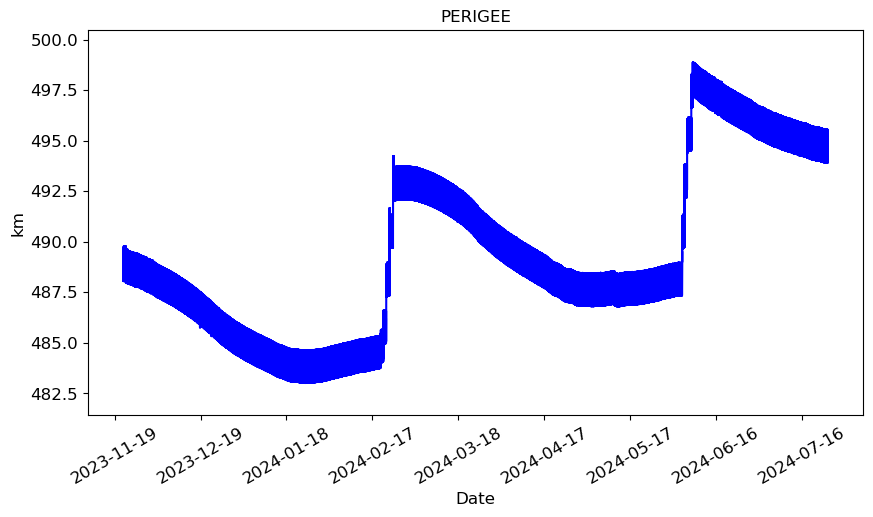

In [45]:
draw_graph(df_2, name.upper(), 'km',
           pd.DataFrame(df_2.iloc[[]].index.date).drop_duplicates().values.tolist(), "blue")

In [1]:
plt.figure(figsize=(10, 5))

plt.plot(df_2.iloc[2000:2300].index, df_2.iloc[2000:2300].values, color='Blue')
plt.scatter(df_2.iloc[ol_idxs].index, df_2.iloc[ol_idxs], c='tab:red', s=10)

set_plot_params(name.upper(), 'dv/dt')
ylim_min, ylim_max = calculate_ylim(list(df_2.iloc[2000:2300].values))
plt.ylim(ylim_min, ylim_max)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(df_2.iloc[2000:2300].index, df_2.iloc[2000:2300].values, color='Blue')
# plt.scatter(df_2.iloc[ol_idxs].index, df_2.iloc[ol_idxs], c='tab:red', s=10)

set_plot_params(name.upper(), 'km')
ylim_min, ylim_max = calculate_ylim(list(df_2.iloc[2000:2300].values))
plt.ylim(ylim_min, ylim_max)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(df_2.iloc[:650, :].index, df_2.iloc[:650, :].values, color='Blue')
# plt.scatter(df_2.iloc[ol_idxs].index, df_2.iloc[ol_idxs], c='tab:red', s=10)

set_plot_params('ALTITUDE_5day', 'km')
ylim_min, ylim_max = calculate_ylim(list(df_2.iloc[:650, :].values))
plt.ylim(ylim_min, ylim_max)
plt.show()